# Create a Lightcurve Simulator in Gammapy-0.20

This notebook is optimized to reproduce Fermi-GBM Light Curves

## 0 - Setup: import packages of the environment gammapy-0.20

In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm, PowerNorm
import matplotlib.lines as mlines

import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table, QTable, hstack
from astropy.io import fits

import logging

import os

import yaml
from yaml import SafeLoader

In [2]:
from gammapy.data import Observation
from gammapy.datasets import SpectrumDataset, Datasets, FluxPointsDataset
from gammapy.estimators import LightCurveEstimator
from gammapy.irf import (
    EffectiveAreaTable2D,
    Background2D, Background3D,
    EnergyDispersion2D, EDispKernel, EDispKernelMap,
)
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom, TimeMapAxis
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    SkyModel,
    LightCurveTemplateTemporalModel
)
from gammapy.utils.random import get_random_state

## 0 - Setup: Define Functions

In [3]:
def Define_Reference_Time(name_file_fits, name_hdu='PRIMARY'):
    """
    Return the Burst Trigger Time as an `astropy.time.Time` object
    to be used as Reference Time of the simulated observations.

    Parameters
    ----------
    name_file_fits: str
        Name of a FITS file that must be opened to get the Trigger Time information.
    name_hdu: str
        Name of the HDU that contains the fields: 'TIMESYS', 'MJDREFI', 'MJDREFF', 'TRIGTIME'.

    Returns
    -------
    `astropy.time.Time`
    """

    hdulist = fits.open(name_file_fits)
    Timesys = hdulist['PRIMARY'].header['TIMESYS'].lower()
    Reference_time = hdulist['PRIMARY'].header['MJDREFI']
    Reference_time+= hdulist['PRIMARY'].header['MJDREFF']
    Reference_time+= hdulist['PRIMARY'].header['TRIGTIME'] / 86400.0
    hdulist.close()

    return Time(Reference_time, format = 'mjd', scale = Timesys)


In [4]:
def Define_Pointing_Direction(name_file_fits, name_hdu='PRIMARY'):
    """
    Return the Pointing Direction as an `astropy.coordinates.SkyCoord` object
    to be used as FoV (0,0) of the simulated observations.

    Parameters
    ----------
    name_file_fits: str
        Name of a FITS file that must be opened to get the Pointing direction information.
    name_hdu: str
        Name of the HDU that contains the fields: 'RA_OBJ' and 'DEC_OBJ' in degrees, 'RADECSYS'.

    Returns
    -------
    `astropy.coordinates.SkyCoord`
    """

    hdulist = fits.open(name_file_fits)
    RA_obj  = hdulist['PRIMARY'].header['RA_OBJ' ]
    DEC_obj = hdulist['PRIMARY'].header['DEC_OBJ']
    Frame   = hdulist['PRIMARY'].header['RADECSYS'].lower()
    hdulist.close()

    return SkyCoord(RA_obj, DEC_obj, unit = "deg", frame = Frame)


In [5]:
def Define_Energy_Axis(name_file_fits,
                       name_hdu,
                       energy_is_true = False,
                       interpolation_mode = "log",
                       slice_energy = False,
                       energy_custom_range = None
                      ):
    """
    Returns an Energy Axis.

    Parameters
    ----------
    name_file_fits: str
        Name of a FITS file that must be opened to get the Energy Axis information.
    name_hdu: str
        Name of the HDU that contains the Energy Axis information.
    energy_is_true: bool
        True if we want to create a True Energy Axis, False for a Reconstructed Energy Axis.
    interpolation_mode: str
        Either "lin" or "log".
    slice_energy: bool
        True if you want to work with a custom energy range.
    energy_custom_range: `astropy.units.Quantity`
        A tuple with 2 values: start and stop of the requested energy range.

    Returns
    -------
    `gammapy.maps.MapAxis`
    """

    # Load Energy Table
    hdulist = fits.open(name_file_fits)
    energy_table = Table.read(hdulist[name_hdu])
    hdulist.close()

    # True or Reconstructed Energy?        
    if energy_is_true:
        energy_col_names = ("ENERG_LO", "ENERG_HI")
        energy_axis_name = "energy_true"
    else:
        energy_col_names = ("E_MIN", "E_MAX")
        energy_axis_name = "energy"
    
    # Define Edges Columns
    energy_col_min = energy_table[energy_col_names[0]].quantity
    energy_col_max = energy_table[energy_col_names[1]].quantity
    
    if energy_col_min.unit is u.Unit(""):
        print("Adimensional values. Correct into ", energy_custom_range.unit)
        energy_col_min = energy_col_min * energy_custom_range.unit
        energy_col_max = energy_col_max * energy_custom_range.unit
    
    # To avoid that min edge is 0
    energy_col_min[0] += 1e-2 * (energy_col_max[0] - energy_col_min[0])

    # Define Edges
    energy_edges = np.append(energy_col_min.value, energy_col_max.value[-1]) * energy_col_min.unit

    # Define Axis
    energy_axis = MapAxis.from_edges(energy_edges,
                                      name = energy_axis_name,
                                      interp = interpolation_mode
                                     )
    
    # Slice Energy
    if slice_energy:
        range_message = f"Original energy range: [{np.round(energy_axis.bounds[0].value,3)}, {np.round(energy_axis.bounds[1].value,3)}] "
        range_message+= str(energy_axis.unit) + f". Energy bins: {energy_axis.nbin}.\n"
        print(range_message)
        
        dummy_array = energy_axis.edges - energy_custom_range[0]
        i_start_energy = np.argmin(np.abs(dummy_array.value))

        dummy_array = energy_axis.edges - energy_custom_range[1]
        i_stop_energy  = np.argmin(np.abs(dummy_array.value))

        energy_axis = energy_axis.slice(slice(i_start_energy, i_stop_energy))

        range_message = f"Current  energy range: [{np.round(energy_axis.bounds[0].value,3)}, {np.round(energy_axis.bounds[1].value,3)}] "
        range_message+= str(energy_axis.unit)+f". Energy bins: {energy_axis.nbin}.\n"
        print(range_message)

    return energy_axis
    

In [6]:
def Define_Response_Matrix(name_file_fits,
                           name_hdu,
                           slice_energy      = False,
                           energy_reco_axis  = None,
                           energy_reco_range = None,
                           energy_true_axis  = None,
                           energy_true_range = None
                          ):
    """
    Return the Detector Response Matrix as a function of true and reconstructed energy with their unit.

    Parameters
    ----------
    name_file_fits: str
        Name of a FITS file that must be opened to get the Energy Axis information.
    name_hdu: str
        Name of the HDU that contains the Energy Axis information.
    slice_energy: bool
        True if you want to work with a custom energy range.
    energy_reco_axis: `gammapy.maps.MapAxis`
        Reconstructed Energy Axis.
    energy_reco_range: `astropy.units.Quantity`
        A tuple with 2 values: start and stop of the requested reconstructed energy range.
    energy_true_axis: `gammapy.maps.MapAxis`
        True Energy Axis.
    energy_true_range: `astropy.units.Quantity`
        A tuple with 2 values: start and stop of the requested true energy range.

    Returns
    -------
    `astropy.units.Quantity`
    """

    # Load the Response
    hdulist = fits.open(name_file_fits)
    DRM_hdu = hdulist[name_hdu]
    DRM_header = DRM_hdu.header
    DRM_data = DRM_hdu.data
    DRM_unit = u.Unit(hdulist[name_hdu].header['TUNIT6'])

    # Define the Matrix
    DRM = np.zeros([len(DRM_data), DRM_header["DETCHANS"]], dtype = np.float64)

    for i, l in enumerate(DRM_data):
        if l.field("N_GRP"):
            m_start = 0
            for k in range(l.field("N_GRP")):
            
                if np.isscalar(l.field("N_CHAN")):
                    f_chan = l.field("F_CHAN")    -1 # Should this be here?
                    n_chan = l.field("N_CHAN")
                else:
                    f_chan = l.field("F_CHAN")[k] -1 # Should this be here?
                    n_chan = l.field("N_CHAN")[k]

                DRM[i, f_chan : f_chan+n_chan] = l.field("MATRIX")[m_start : m_start+n_chan]
                m_start += n_chan

    
    # Values are set.
    
    hdulist.close()
    
    if slice_energy:
        
        # True
        dummy_array = energy_true_axis.edges - energy_true_range[0]
        i_start_energy_true = np.argmin(np.abs(dummy_array.value))

        dummy_array = energy_true_axis.edges - energy_true_range[1]
        i_stop_energy_true  = np.argmin(np.abs(dummy_array.value))
        
        # Reco
        dummy_array = energy_reco_axis.edges - energy_reco_range[0]
        i_start_energy_reco = np.argmin(np.abs(dummy_array.value))

        dummy_array = energy_reco_axis.edges - energy_reco_range[1]
        i_stop_energy_reco  = np.argmin(np.abs(dummy_array.value))
        
        # Slice        
        DRM = DRM[i_start_energy_true:i_stop_energy_true, i_start_energy_reco:i_stop_energy_reco]
    
    return DRM * DRM_unit


In [7]:
def Define_Background_Spectrum(name_file_fits,
                               name_ebounds = 'EBOUNDS',
                               name_spectrum = 'SPECTRUM',
                               geometry = None,
                               energy_unit = u.keV,
                               time_unit = u.s,
                               slice_energy = False,
                               energy_reco_range = None
                              ):
    """
    Return the background Spectral Model.

    Parameters
    ----------
    name_file_fits: str
        Name of a FITS file that must be opened to get the Energy Axis information.
    name_hdu: str
        Name of the HDU that contains the Energy Axis information.

    Returns
    -------
    `astropy.units.Quantity`
    """
    
    hdulist = fits.open(name_file_fits)
    
    # Define the Background Table
    table_ebounds = QTable.read( hdulist[name_ebounds ] )
    table_spectrum= QTable.read( hdulist[name_spectrum] )
    
    hdulist.close()
    # Merge Tables
    table = QTable()
    
    if table_ebounds['E_MIN'].unit is None:
        table_ebounds['E_MIN'] = table_ebounds['E_MIN'] * energy_unit
        table_ebounds['E_MAX'] = table_ebounds['E_MAX'] * energy_unit
    if table_spectrum['RATE'].unit is None:
        table_spectrum['RATE'] = table_spectrum['RATE'] / time_unit
    
    table['E_MIN'] = table_ebounds['E_MIN']
    table['E_MAX'] = table_ebounds['E_MAX']
    table['RATE' ] = table_spectrum['RATE']

    table['BKG_MOD'] = table['RATE'] / (table['E_MAX'] - table['E_MIN'])
    table['BKG_MOD'] = table['BKG_MOD'] / geometry.solid_angle()
    
    
    if slice_energy:
        
        edges = np.append(table['E_MIN'].value, table['E_MAX'].value[-1]) * table['E_MIN'].unit

        dummy_array = edges - energy_reco_range[0]
        i_start_energy_reco = np.argmin(np.abs(dummy_array.value))

        dummy_array = edges - energy_reco_range[1]
        i_stop_energy_reco  = np.argmin(np.abs(dummy_array.value))
        
        table = table[i_start_energy_reco: i_stop_energy_reco]
        
    
    return table['BKG_MOD']


## 0 - Setup: Define YAML file name

In [8]:
# yaml_file = "/home/gabriele/Documents/gammapy/LCsim/Input/GRB120323A_GBM_b0_15ms_250_40000_keV.yaml"
# yaml_file = "/home/gabriele/Documents/gammapy/LCsim/Input/GRB120323A_GBM_n0_10ms_10_900_keV.yaml"

# yaml_file = "/home/gabriele/Documents/gammapy/LCsim/Input/GRB160530A_GBM_b0_200ms_250_10000_keV.yaml"
# yaml_file = "/home/gabriele/Documents/gammapy/LCsim/Input/GRB160530A_GBM_b0_200ms_250_40000_keV.yaml"
# yaml_file = "/home/gabriele/Documents/gammapy/LCsim/Input/GRB160530A_GBM_n0_200ms_10_900_keV.yaml"
# yaml_file = "/home/gabriele/Documents/gammapy/LCsim/Input/GRB160530A_GBM_n1_200ms_10_900_keV.yaml"


In [9]:
yaml_file = "/home/gabriele/Documents/gammapy/LCsim/Input/GRB160530A_GBM_b0_200ms_250_10000_keV.yaml"

# 1 - Load the YAML file and define the input parameters

In [10]:
with open(yaml_file) as f:
    data = yaml.load(f, Loader = SafeLoader)
###############################################################


# Transient Information
Name_transient = data['Name_GRB']
Name_instrument= data['Name_instrument']
Name_detector  = data['Name_detector']


# Input Files
File_bak = data['Input_bak']
File_rsp = data['Input_rsp']
File_lightcurve = data['Input_lightcurve']


# Energy Axes Parameters
Energy_interpolation = data['Energy_interpolation']
Energy_slice = data['Energy_slice']
Energy_unit = u.Unit(data["Energy_unit"])

custom_range_energy_reco = tuple(data['Energy_range_reco']) * Energy_unit
custom_range_energy_true = tuple(data['Energy_range_true']) * Energy_unit


# Observation Parameters
Number_of_LightCurves = data['N_light_curves']
Time_unit = u.Unit(data['Time_unit'])

t_start_obs= data['Observation_time_start'] * Time_unit
t_stop_obs = data['Observation_time_stop' ] * Time_unit
live_t_obs = data['Observation_livetimes' ] * Time_unit
dead_times = data['Observation_deadtimes' ] * Time_unit


# Spectral fit time range and parameters
spectral_fit_time_range = data['Specfit_time_range'] * Time_unit

GBM_Ampli = data['Specfit_amplitude'] * u.Unit(data['Specfit_amplitude_unit'])
GBM_Index = data['Specfit_index'] * u.Unit("")
GBM_Epeak = data['Specfit_epeak'] * Energy_unit
GBM_Erefe = data['Specfit_erefe'] * Energy_unit


# Create Output Directory

output_directory = data['Output_directory']
output_directory+= Name_transient + '/'
output_directory+= Name_instrument + '_' + Name_detector + '_'
output_directory+= str(int(live_t_obs.to('ms').value)) + 'ms_'
output_directory+= str(int(custom_range_energy_reco.value[0])) + '_'
output_directory+= str(int(custom_range_energy_reco.value[1])) + '_'
output_directory+= Energy_unit.to_string()+'/'

if data['Output_run_id'] is not None:
    output_directory += data['Output_run_id']+'/'

os.makedirs(os.path.dirname(output_directory), exist_ok=True)

# 2 - Define Reference System

Define Reference Time.

Define Pointing Direction.

Define Instrument FoV axes: Offset, Lon, Lat.

#### 2.1 - Define the Reference Time of the simulated observations as the Trigger Time

In [11]:
# Define the Trigger Time as the Reference Time of the simulated observations
trigger_time_t0 = Define_Reference_Time(File_rsp)

# Define preferred time format
TimeMapAxis.time_format = "iso" 
trigger_time_t0.format = TimeMapAxis.time_format

# Print
trigger_time_t0

<Time object: scale='tt' format='iso' value=2016-05-30 16:02:20.013>

#### 2.2 - Define the Pointing Direction of the simulated observations and the FoV (Lon, Lat, Offset) axes

In [12]:
# Define the (RA_OBJ, DEC_OBJ) coordinates as the Pointing Direction of the simulated observations
pointing = Define_Pointing_Direction(File_rsp)

# Print
pointing

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (133.5, 43.5)>

**Define Instrument FoV Axes**

In [13]:
# Assumption: The FoV Center is (0,0), FoV_Lon and FoV_Lat are symmetric wrt to 0.0

fov_maximum_offset = 5.0 * u.deg
fov_n_bin = 5

# Create Offset axis
axis_offset = MapAxis.from_bounds(0.0, fov_maximum_offset.value,
                                  unit = fov_maximum_offset.unit, nbin = fov_n_bin, name = "offset"
                                 )
# Create Instrument FoV_lon axis
axis_fovlon = MapAxis.from_bounds(-fov_maximum_offset.value/2.0, +fov_maximum_offset.value/2.0,
                                  unit = fov_maximum_offset.unit, nbin = fov_n_bin, name = "fov_lon"
                                 )
# Create Instrument FoV_lat axis
axis_fovlat = MapAxis.from_bounds(-fov_maximum_offset.value/2.0, +fov_maximum_offset.value/2.0,
                                  unit = fov_maximum_offset.unit, nbin = fov_n_bin, name = "fov_lat"
                                 )

# Print
print(axis_offset)
print(axis_fovlon)
print(axis_fovlat)

MapAxis

	name       : offset    
	unit       : 'deg'     
	nbins      : 5         
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 5.0e+00 deg
	interp     : lin       

MapAxis

	name       : fov_lon   
	unit       : 'deg'     
	nbins      : 5         
	node type  : edges     
	edges min  : -2.5e+00 deg
	edges max  : 2.5e+00 deg
	interp     : lin       

MapAxis

	name       : fov_lat   
	unit       : 'deg'     
	nbins      : 5         
	node type  : edges     
	edges min  : -2.5e+00 deg
	edges max  : 2.5e+00 deg
	interp     : lin       



#### 2.3 - Define Observation Starting Times and Livetimes

In [14]:
# Estimate Number of observations
n_obs = (t_stop_obs-t_start_obs)/live_t_obs
n_obs = int(np.floor(n_obs.value))

# Define starting time of each observation linearly spaced during the night
starting_times = np.linspace(t_start_obs.value,
                             t_stop_obs.value,
                             num = n_obs
                            )
starting_times = starting_times.tolist() * Time_unit

# Define the duration of each observation as the difference between two following starting times
# minus the rest time between them.
livetimes = starting_times[1:] - starting_times[:-1] - dead_times

# Remove last edge to have the same array dimesion for starting times and livetimes.
starting_times = starting_times[:-1]

# Turn them from astropy.units.quantity.Quantity to astropy.time.core.Time with t_ref
starting_times = Time(trigger_time_t0 + starting_times)

# Adjust n_obs
n_obs = starting_times.size

print(n_obs)

124


#### 2.4 - Load Empirical Light Curve and slice to observation time range

In [15]:
# Load the Table with the empirical lightcurve
LC_empirical = QTable.read(File_lightcurve, format = 'fits')


# Let's find the time points of the Empirical Light Curve closest to start and stop of observations. 
LC_emp_i_start= np.argmin(np.abs(LC_empirical['time'].value - t_start_obs.value))
LC_emp_i_stop = np.argmin(np.abs(LC_empirical['time'].value - t_stop_obs.value ))

LC_emp = LC_empirical[LC_emp_i_start:LC_emp_i_stop]

# Empirical Light Curve Data for plot

# Time
LCe_time_val = LC_emp['time'      ].value
LCe_time_wid = LC_emp['time_width'].value

# Count rates
LCe_cnt_rate = LC_emp['cnt_rt'    ].value
LCe_cnt_erro = LC_emp['cnt_rt_err'].value

# Background rates
LCe_bkg_rate = LC_emp['bkg_rt'    ].value
LCe_bkg_erro = LC_emp['bkg_rt_err'].value

# Excess rates
LCe_exc_rate = LCe_cnt_rate - LCe_bkg_rate
LCe_exc_erro = LCe_cnt_erro + LCe_bkg_erro

# Model: best fit excess rates
LCe_exc_pred = LC_emp['best_model'].value

## 3 - Define the Detector Response

Define True and Reconstructed Energy Axes.

Load the Detector Response Matrix.

Define the Effective Area.



#### 3.1 - Define the True and Reconstructed Energy Axis

The Reconstructed Energy Axis is defined from the EBOUNDS hdu of the response file.

The True Energy Axis is defined from the SPECRESP MATRIX hdu of the response file.

In [16]:
# Define Reconstructed Energy Axis

print("Reconstructed Energy Axis\n")
axis_energy_reco = Define_Energy_Axis(File_rsp,
                                      "EBOUNDS",
                                      energy_is_true = False,
                                      interpolation_mode = Energy_interpolation,
                                      slice_energy = Energy_slice,
                                      energy_custom_range = custom_range_energy_reco
                                     )

print("\nTrue Energy Axis\n")
axis_energy_true = Define_Energy_Axis(File_rsp,
                                      "SPECRESP MATRIX",
                                      energy_is_true = True,
                                      interpolation_mode = Energy_interpolation,
                                      slice_energy = Energy_slice,
                                      energy_custom_range = custom_range_energy_true
                                     )

# Print
print(axis_energy_reco)
print(axis_energy_true)

Reconstructed Energy Axis

Original energy range: [116.24, 50000.0] keV. Energy bins: 128.

Current  energy range: [254.011, 9854.985] keV. Energy bins: 88.


True Energy Axis

Original energy range: [100.056, 200000.0] keV. Energy bins: 140.

Current  energy range: [202.546, 14765.5] keV. Energy bins: 79.

MapAxis

	name       : energy    
	unit       : 'keV'     
	nbins      : 88        
	node type  : edges     
	edges min  : 2.5e+02 keV
	edges max  : 9.9e+03 keV
	interp     : log       

MapAxis

	name       : energy_true
	unit       : 'keV'     
	nbins      : 79        
	node type  : edges     
	edges min  : 2.0e+02 keV
	edges max  : 1.5e+04 keV
	interp     : log       



#### 3.2 - Define Source Geometry

In [17]:
# Define the Source Geometry: a region in the sky where the source is placed.

geometry_radius = 1.0 * u.deg

source_geometry_str = pointing.frame.name + ';circle('
source_geometry_str+= pointing.to_string().split()[0] + ', '
source_geometry_str+= pointing.to_string().split()[1] + ', '
source_geometry_str+= str(geometry_radius.value) + ')'

geom = RegionGeom.create(source_geometry_str, axes = [axis_energy_reco])

# Print
print(geom)

RegionGeom

	region     : CircleSkyRegion
	axes       : ['lon', 'lat', 'energy']
	shape      : (1, 1, 88)
	ndim       : 3
	frame      : fk5
	center     : 133.5 deg, 43.5 deg



#### 3.3 - Load the Spectral Response Matrix

The Matrix is defined from the SPECRESP MATRIX hdu of the response file.

In [18]:
DRM_quantity = Define_Response_Matrix(File_rsp,
                                      "SPECRESP MATRIX",
                                      slice_energy      = True,
                                      energy_reco_axis  = axis_energy_reco,
                                      energy_reco_range = custom_range_energy_reco,
                                      energy_true_axis  = axis_energy_true,
                                      energy_true_range = custom_range_energy_true
                                     )
#DRM_quantity

#### 3.4 - Define the Effective Area

In [19]:
# Compute Effective Area array (as a function of True Energy)
aeff_array = np.sum(DRM_quantity.value, axis=1)

# Compute Effective Area matrix (as a function of True Energy and Offset)
aeff_matrix = np.ndarray( (axis_energy_true.nbin, axis_offset.nbin) )

for i in range(axis_offset.nbin):
    aeff_matrix.transpose()[i] = aeff_array

# Instantiate Effective Area object
aeff = EffectiveAreaTable2D(axes = [axis_energy_true, axis_offset],
                            data = aeff_matrix,
                            unit = DRM_quantity.unit
                            # meta = metadata dictionary from header
                           )
# Print
print(aeff)
print(f"Total effective area: {np.sum(DRM_quantity)}.")

EffectiveAreaTable2D
--------------------

  axes  : ['energy_true', 'offset']
  shape : (79, 5)
  ndim  : 2
  unit  : cm2
  dtype : float64

Total effective area: 12864.379736638442 cm2.


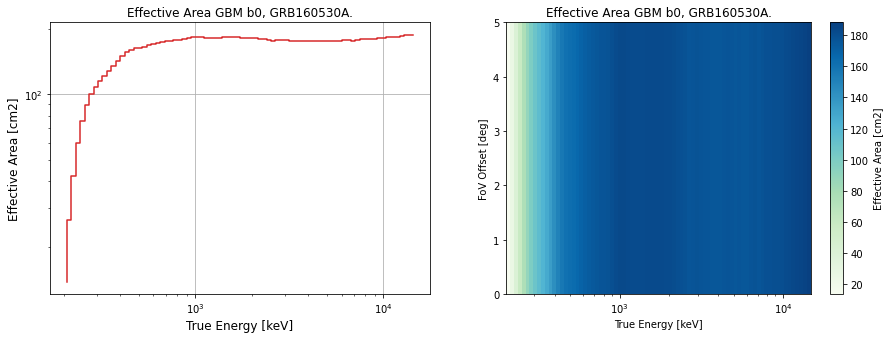

In [20]:
# Plot and save
fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].step(axis_energy_true.center.value, aeff_array, c='C3')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('True Energy ['+axis_energy_true.unit.to_string()+']', fontsize = 'large')
axs[0].set_ylabel('Effective Area ['+aeff.unit.to_string()+']', fontsize = 'large')
axs[0].set_title("Effective Area "+Name_instrument+" "+Name_detector+", "+Name_transient+".", fontsize = 'large')
axs[0].grid()

aeff.plot(ax = axs[1], add_cbar = True)
axs[1].set_title("Effective Area "+Name_instrument+" "+Name_detector+", "+Name_transient+".", fontsize = 'large')
axs[1].set_xscale('log')

fig.savefig(output_directory + "IRF_effective_area.png",
            facecolor = 'white'
           )

plt.show()

#### 3.5 - Define Energy Dispersion Matrix

In [21]:
# Build Kernel
edisp = EDispKernel(axes = [axis_energy_true, axis_energy_reco], data = DRM_quantity.value)

# Build EDispKernelMap
edisp = EDispKernelMap.from_edisp_kernel(edisp, geom = geom)

# Normalize data
DRM_normalized = np.zeros(np.shape(edisp.edisp_map.data.T[0][0].T))
for i, r in enumerate(edisp.edisp_map.data.T[0][0].T):
    norm_row = np.sum(r)
    if norm_row != 0.0:
        DRM_normalized[i] = r / norm_row
    
DRM_normalized = np.reshape(DRM_normalized, np.shape(edisp.edisp_map.data))
edisp.edisp_map.data = DRM_normalized


In [22]:
# Check Normalization
# for r in edisp.edisp_map.data.T[0][0].T:
#     print(len(r), np.sum(r))

# Peek
#edisp.peek()

In [23]:
# Set correct Units for exposure map
edisp.exposure_map = edisp.exposure_map.to_unit(aeff.unit * Time_unit)

# Initialize the Exposure with effective area values * livetimes. Assume all lifetimes are equal
edisp.exposure_map.data *= 0.0
edisp.exposure_map.data += np.reshape( aeff.data.T[0], edisp.exposure_map.data.T.shape ).T
edisp.exposure_map.data *= livetimes[0].value

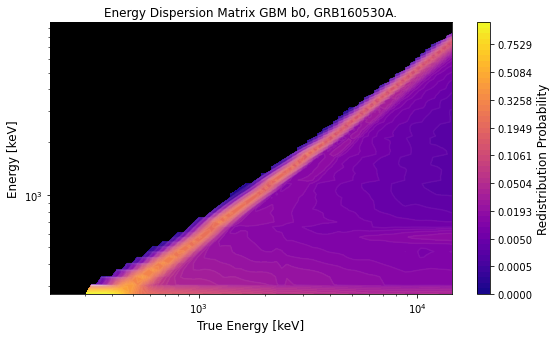

In [24]:
# Prepare Grid
X, Y = np.meshgrid(axis_energy_true.center.value, axis_energy_reco.center.value)

# Copy Data with Masking
Z = np.ma.masked_where(edisp.edisp_map.data.T[0][0] <= 0, edisp.edisp_map.data.T[0][0])

# Plot
fig, ax = plt.subplots(1, figsize=(9,5))

# Define Levels
levs = np.linspace(np.floor(np.power(Z.min(),0.3)),
                   np.ceil( np.power(Z.max(),0.3)),
                   num = 50
                  )
levs = np.power(levs, 1.0/0.3)

# Plot Data
cs = ax.contourf(X, Y, Z, levs, norm = PowerNorm(gamma=0.3), cmap = 'plasma')
ax.contour(X, Y, Z, levs, norm = PowerNorm(gamma=0.3), colors='white', alpha=0.05)
cbar = fig.colorbar(cs)

# Labels
ax.set_facecolor('k')
ax.set_xscale('log')
ax.set_yscale('log')
cbar.set_label('Redistribution Probability', fontsize = 'large')
ax.set_xlabel('True Energy ['+axis_energy_true.unit.to_string()+']', fontsize = 'large')
ax.set_ylabel('Energy ['     +axis_energy_reco.unit.to_string()+']', fontsize = 'large')
ax.set_title("Energy Dispersion Matrix "+Name_instrument+" "+Name_detector+", "+Name_transient+".",
             fontsize = 'large'
            )

# Save figure
fig.savefig(output_directory + "IRF_energy_dispersion_matrix.png",
            facecolor = 'white'
           )

plt.show()

#### Define Energy Dispersion from a gaussian

In [25]:
# # Build Gaussian Kernel
# edisp_gauss = EDispKernel.from_gauss(energy_axis_true = axis_energy_true,
#                                      energy_axis      = axis_energy_reco,
#                                      bias             = 0,
#                                      sigma            = 0.1
#                                     )
# # Build Gaussian EDispKernelMap
# edisp_gauss = EDispKernelMap.from_edisp_kernel(edisp_gauss, geom = geom)

# # Peek
# edisp_gauss.peek()

# # Check normalization
# for r in edisp_gauss.edisp_map.data.T[0][0].T:
#     print(len(r), np.sum(r))


# # Set correct Units for exposure map
# edisp_gauss.exposure_map = edisp_gauss.exposure_map.to_unit(aeff.unit * Time_unit)

# # Initialize the Exposure with effective area values * livetimes. Assume all lifetimes are equal
# edisp_gauss.exposure_map.data += np.reshape(aeff.data.T[0], (1,1,1,80)).T
# edisp_gauss.exposure_map.data *= livetimes[0].value

## 4 - Define the Background Spectral Model 

Define appropriate reco energy axis and slice

In [26]:
axis_energy_reco_bkg = Define_Energy_Axis(File_bak,
                                          "EBOUNDS",
                                          energy_is_true = False,
                                          interpolation_mode = Energy_interpolation,
                                          slice_energy = Energy_slice,
                                          energy_custom_range = custom_range_energy_reco
                                         )
print(axis_energy_reco_bkg)

Adimensional values. Correct into  keV
Original energy range: [114.283, 50000.0] keV. Energy bins: 128.

Current  energy range: [250.773, 10067.767] keV. Energy bins: 89.

MapAxis

	name       : energy    
	unit       : 'keV'     
	nbins      : 89        
	node type  : edges     
	edges min  : 2.5e+02 keV
	edges max  : 1.0e+04 keV
	interp     : log       



In [27]:
# Load Background
bak_model = Define_Background_Spectrum(File_bak,
                                       name_ebounds = 'EBOUNDS',
                                       name_spectrum = 'SPECTRUM',
                                       geometry = geom,
                                       energy_unit = Energy_unit,
                                       time_unit = Time_unit,
                                       slice_energy = Energy_slice,
                                       energy_reco_range = custom_range_energy_reco
                                      )

# Prepare Background Matrix (as a function of energy, lon and lat) as ndarray
data_bkg = np.ndarray( (axis_energy_reco_bkg.nbin, axis_fovlon.nbin, axis_fovlat.nbin) )

for i in range(axis_fovlat.nbin):
    for j in range(axis_fovlon.nbin):
        data_bkg.transpose()[i][j] = bak_model.value

# Instantiate Background object # I should add meta=metadata dictionary from header    
bkg = Background3D(axes = [axis_energy_reco_bkg, axis_fovlon, axis_fovlat],
                   data = data_bkg,
                   unit = bak_model.unit,
                   #is_pointlike = False,
                   #fov_alignment = FoVAlignment.RADEC,
                   #meta = None,
                   #interp_kwargs = None
                   )

# Print
print(bkg)
# bkg.peek()

Background3D
------------

  axes  : ['energy', 'fov_lon', 'fov_lat']
  shape : (89, 5, 5)
  ndim  : 3
  unit  : 1 / (keV s sr)
  dtype : float64



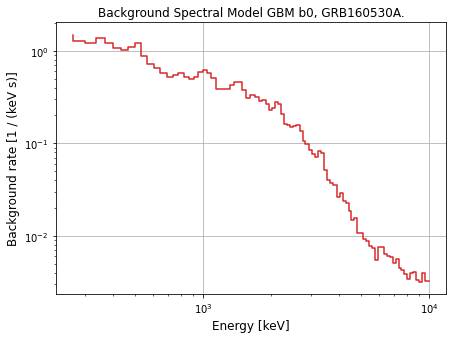

In [28]:
# Plot and save
fig, ax = plt.subplots(1, figsize=(7,5))

bak_to_plot = bak_model*geom.solid_angle()
ax.step(axis_energy_reco_bkg.center.value,
        bak_to_plot,
        color = 'C3'
       )
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Energy ["+axis_energy_reco_bkg.unit.to_string()+"]", fontsize = 'large')
ax.set_ylabel("Background rate ["+bak_to_plot.unit.to_string()+"]", fontsize = 'large')
ax.set_title("Background Spectral Model "+Name_instrument+" "+Name_detector+", "+Name_transient+".",
             fontsize = 'large'
            )
ax.grid()

# Save figure
fig.savefig(output_directory + "IRF_background_spectrum.png",
            facecolor = 'white'
           )

plt.show()

### Define the IRFs dictionary

In [29]:
IRFs = {'aeff' : aeff,
        'bkg'  : bkg
       }

## 5 - Define Temporal and Spectral Model for the simulated source

In [30]:
# Temporal model
Temporal_Model_Table_Metadata = {'MJDREFI' : int(np.modf(trigger_time_t0.mjd)[1]),
                                 'MJDREFF' :     np.modf(trigger_time_t0.mjd)[0],
                                 'TIMEUNIT': LC_empirical['time'].unit.to_string(),
                                 'TIMESYS' : trigger_time_t0.scale
                                }

Temporal_Model_Table = Table(meta = Temporal_Model_Table_Metadata)
Temporal_Model_Table['TIME'] = LC_empirical['time']
Temporal_Model_Table['NORM'] = LC_empirical['norm']

Temporal_Model = LightCurveTemplateTemporalModel(Temporal_Model_Table)

# Print
print(Temporal_Model)

LightCurveTemplateTemporalModel model summary:
Start time: 57538.66713093178 MJD
End time: 57538.66944343178 MJD
Norm min: 7.393591742444048e-33
Norm max: 1.0



In [31]:
# Evaluate Temporal model at maximum, should return 1
# print(temporal_model.evaluate(trigger_time_t0.mjd+0.075/86400.0))

# Evaluate correction factor
correction_factor = [trigger_time_t0.mjd + spectral_fit_time_range[0].to("day").value,
                     trigger_time_t0.mjd + spectral_fit_time_range[1].to("day").value
                    ]
correction_factor = Time(correction_factor, format = 'mjd')

correction_factor = Temporal_Model.integral(correction_factor[0], correction_factor[1])
print(correction_factor)

0.8821103140498466


In [32]:
# Spectral model
Spectral_Model = ExpCutoffPowerLawSpectralModel(amplitude = GBM_Ampli / correction_factor,
                                                index     = - GBM_Index,
                                                lambda_   = (2.0 + GBM_Index ) / GBM_Epeak,
                                                reference = GBM_Erefe
                                               )
# Print
print(Spectral_Model)

ExpCutoffPowerLawSpectralModel

  type      name     value         unit        error   min max frozen is_norm link
-------- --------- ---------- -------------- --------- --- --- ------ ------- ----
spectral     index 6.2700e-01                0.000e+00 nan nan  False   False     
spectral amplitude 6.2350e-01 cm-2 keV-1 s-1 0.000e+00 nan nan  False    True     
spectral reference 1.0000e+02            keV 0.000e+00 nan nan   True   False     
spectral   lambda_ 5.2909e-03          keV-1 0.000e+00 nan nan  False   False     
spectral     alpha 1.0000e+00                0.000e+00 nan nan   True   False     


In [33]:
# Complete Source Model = Temporal & Spectral
model_simu = SkyModel(spectral_model = Spectral_Model,
                      temporal_model = Temporal_Model,
                      name           = "Compt-Empirical"
                     )

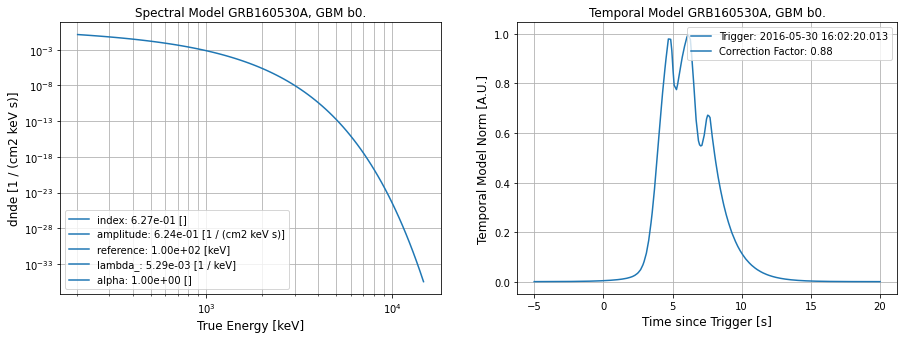

<Table length=5>
  type      name     value         unit        error     min     max   frozen is_norm link
  str8      str9    float64       str14        int64   float64 float64  bool    bool  str1
-------- --------- ---------- -------------- --------- ------- ------- ------ ------- ----
spectral     index 6.2700e-01                0.000e+00     nan     nan  False   False     
spectral amplitude 6.2350e-01 cm-2 keV-1 s-1 0.000e+00     nan     nan  False    True     
spectral reference 1.0000e+02            keV 0.000e+00     nan     nan   True   False     
spectral   lambda_ 5.2909e-03          keV-1 0.000e+00     nan     nan  False   False     
spectral     alpha 1.0000e+00                0.000e+00     nan     nan   True   False

In [37]:
# Print and Save
fig, axs = plt.subplots(1,2, figsize = (15,5) )

# Spectral Model
if Energy_interpolation == 'lin':
    energies_to_plot = np.linspace(axis_energy_true.edges[0], axis_energy_true.edges[-1], num=100)
elif Energy_interpolation == 'log':
    energies_to_plot = np.linspace(np.log10(axis_energy_true.edges[0].value),
                                   np.log10(axis_energy_true.edges[-1].value),
                                   num = 100
                                  )
    energies_to_plot = np.power(10,energies_to_plot)
    energies_to_plot = energies_to_plot * axis_energy_true.unit

dnde_to_plot = Spectral_Model.evaluate(energies_to_plot,
                                       Spectral_Model.parameters.value[0]*Spectral_Model.parameters[0].unit,
                                       Spectral_Model.parameters.value[1]*Spectral_Model.parameters[1].unit,
                                       Spectral_Model.parameters.value[2]*Spectral_Model.parameters[2].unit,
                                       Spectral_Model.parameters.value[3]*Spectral_Model.parameters[3].unit,
                                       Spectral_Model.parameters.value[4]*Spectral_Model.parameters[4].unit
                                      )

axs[0].plot(energies_to_plot.value, dnde_to_plot.value)

axs[0].set_title("Spectral Model "+Name_transient+", "+Name_instrument+" "+Name_detector+".", fontsize = 'large')
axs[0].set_xlabel("True Energy ["+energies_to_plot.unit.to_string()+"]", fontsize = 'large')
axs[0].set_ylabel("dnde ["+dnde_to_plot.unit.to_string()+"]", fontsize = 'large')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].grid(which="both")

# Temporal Model

times_to_plot = np.linspace(t_start_obs, t_stop_obs, num=300)
norms_to_plot = Temporal_Model.evaluate(trigger_time_t0.mjd + times_to_plot.to("day").value)
axs[1].plot(times_to_plot.value, norms_to_plot)
axs[1].set_title("Temporal Model "+Name_transient+", "+Name_instrument+" "+Name_detector+".", fontsize = 'large')
axs[1].grid(which="both")
axs[1].set_xlabel("Time since Trigger ["+Time_unit.to_string()+"]", fontsize = 'large')
axs[1].set_ylabel("Temporal Model Norm [A.U.]", fontsize = 'large')

# Legends
labels = []
handles = []
for par in Spectral_Model.parameters:
    labels.append(par.name+f": {par.value:.2e} [" +par.unit.to_string()+"]")
    handles.append(mlines.Line2D([], []))
    
axs[0].legend(handles, labels)
axs[1].legend([mlines.Line2D([], []),mlines.Line2D([], [])],
              ["Trigger: "+trigger_time_t0.value,f"Correction Factor: {correction_factor:.2f}"])

# Save Figure
fig.savefig(output_directory + "Models.png",
            facecolor = 'white'
           )

plt.show()

model_simu.parameters.to_table()

# 6 - Simulations

In [38]:
%%time

# Create a List of Datasets, each will be a Light curve
List_of_Datasets = []
# Fill it with empty Datasets
for i_LC in range(Number_of_LightCurves):
    List_of_Datasets.append(Datasets())
    
    
# Create an empty SpectrumDataset object to host geometry and energy info.
empty = SpectrumDataset.create(geom = geom,
                               energy_axis_true = axis_energy_true,
                               name = "empty",
                               edisp = edisp
                              )

# Create Maker object.
# containment_correction must be set True if I have a PSF, to adapt the
# exposure map and account for PSF broadening and the PSF containment.
maker = SpectrumDatasetMaker(selection = ["exposure",
                                          "background"
                                         ],
                             containment_correction = False
                            )

# This mock light curve will store info on the predicted background and excess rates.
# It won't contain any simulation.
datasets_generic = Datasets()

for idx in range(n_obs):
    print(f'Creating Dataset {idx+1}/{n_obs}...             \r', end = '')
    
    # Set the current observation. Observations differ only in their starting time.
    obs = Observation.create(pointing      = pointing,
                             livetime      = livetimes[idx],
                             tstart        = starting_times[idx],
                             irfs          = IRFs,
                             reference_time= trigger_time_t0,
                             obs_id        = idx
                            )
    
    # Set name according to observation number. Set geometry and energy information.
    dataset_generic = empty.copy(name = f"dataset-{idx}")
    
    # Run: creates the SpectrumDataset. It also sets the Background counts.
    dataset_generic = maker.run(dataset_generic, obs)
    
    # Set the Energy Disperison    
    dataset_generic.edisp = edisp
    
    # Set the source model and compute the predicted excess counts from it.
    dataset_generic.models = model_simu
    
    # For this observation simulate background and counts for each different light curve
    for i_LC in range(Number_of_LightCurves):
               
        dataset = dataset_generic.copy(name = f"LC-{i_LC}"+f"--Dataset-{idx}")
        
        # Set models, that CANNOT BE COPIED
        dataset.models = model_simu
        
#        # Introduce Background Fluctuations.
#         random_state = get_random_state('random-seed')
#         data = np.nan_to_num(dataset.npred_background().data,
#                              copy = True, nan = 0.0, posinf = 0.0, neginf = 0.0)
#         data = random_state.poisson(data)
#         dataset.npred_background().data = data
#         dataset.background = dataset.npred_background()
        
        # Simulate counts from Poisson(avg=Predicted Backgrounds+Predicted count excess)
        dataset.fake()
        
        # Add this dataset to the right collection.
        datasets = List_of_Datasets[i_LC]
        datasets.append(dataset)
    
    
    datasets_generic.append(dataset_generic)
    
        
    # Repeat for a new observation.
    
# Loop ended.
print('\nDone.')

Creating Dataset 124/124...             
Done.
CPU times: user 39.8 s, sys: 426 ms, total: 40.2 s
Wall time: 40.2 s


# 7 - Plot and explore results

The model and background information can be seen in the *generic* datasets, where counts have not been faked.

In [39]:
quicklook_table_generic = datasets_generic.info_table()

print('Columns available:\n', quicklook_table_generic.keys())

show_columns = ['name',
                'background',
                'npred_signal',
                'npred',
                'counts',              
                'livetime',
                'counts_rate',
                'background_rate',
                'excess_rate'
               ]
quicklook_table_generic[show_columns][54:59]

Columns available:
 ['name', 'counts', 'excess', 'sqrt_ts', 'background', 'npred', 'npred_background', 'npred_signal', 'exposure_min', 'exposure_max', 'livetime', 'ontime', 'counts_rate', 'background_rate', 'excess_rate', 'n_bins', 'n_fit_bins', 'stat_type', 'stat_sum']


<Table length=5>
   name        background       npred_signal          npred       counts       livetime      counts_rate  background_rate       excess_rate    
                                                                                  s             1 / s          1 / s               1 / s       
  str11         float64           float64            float64      int64        float64         float64        float64             float64      
---------- ----------------- ------------------ ----------------- ------ ------------------- ----------- ------------------ -------------------
dataset-54 259.9053791139361 369.94921374127676 629.8545928552128      0 0.20161290322588954         0.0 1289.1306804045917 -1289.1306804045917
dataset-55 259.9053791139361 374.68413290140126 634.5895120153373      0 0.20161290322588954         0.0 1289.1306804045917 -1289.1306804045917
dataset-56 259.9053791139361 343.94918922801605 603.8545683419522      0 0.20161290322588954         0.0 1289.1306804045917 -1289.1306804045917
dataset-57 259.9053791139361 283.14630787376444 543.0516869877006      0 0.20161290322588954         0.0 1289.1306804045917 -1289.1306804045917
dataset-58 259.9053791139361 230.46680007796778 490.3721791919038      0 0.20161290322588954         0.0 1289.1306804045917 -1289.1306804045917

Quick look to a Light curve

In [40]:
quicklook_table = List_of_Datasets[0].info_table()

print('Columns available:\n',quicklook_table.keys())

show_columns = ['name',
                'background',
                'npred_signal',
                'npred',
                'counts',              
                'livetime',
                'counts_rate',
                'background_rate',
                'excess_rate'
               ]
quicklook_table[show_columns][54:59]

Columns available:
 ['name', 'counts', 'excess', 'sqrt_ts', 'background', 'npred', 'npred_background', 'npred_signal', 'exposure_min', 'exposure_max', 'livetime', 'ontime', 'counts_rate', 'background_rate', 'excess_rate', 'n_bins', 'n_fit_bins', 'stat_type', 'stat_sum']


<Table length=5>
      name           background       npred_signal          npred       counts       livetime         counts_rate      background_rate      excess_rate    
                                                                                        s                1 / s              1 / s              1 / s       
     str17            float64           float64            float64      int64        float64            float64            float64            float64      
---------------- ----------------- ------------------ ----------------- ------ ------------------- ------------------ ------------------ ------------------
LC-0--Dataset-54 259.9053791139361 369.94921374127676 629.8545928552128    640 0.20161290322588954  3174.399999998692 1289.1306804045917 1885.2693195941001
LC-0--Dataset-55 259.9053791139361 374.68413290140126 634.5895120153373    606 0.20161290322588954 3005.7599999987615 1289.1306804045917 1716.6293195941696
LC-0--Dataset-56 259.9053791139361 343.94918922801605 603.8545683419522    615 0.20161290322588954 3050.3999999987427 1289.1306804045917 1761.2693195941513
LC-0--Dataset-57 259.9053791139361 283.14630787376444 543.0516869877006    552 0.20161290322588954  2737.919999998872 1289.1306804045917   1448.78931959428
LC-0--Dataset-58 259.9053791139361 230.46680007796778 490.3721791919038    497 0.20161290322588954  2465.119999998984 1289.1306804045917 1175.9893195943923

Average quantities of the Light Curve

In [41]:
n_rows = Number_of_LightCurves
n_cols = n_obs
    
SIM_matrix_cnt_rate = np.empty( (n_rows, n_cols) )
SIM_matrix_bkg_rate = np.empty( (n_rows, n_cols) )

print('Extracting rates from table...')
for i in range(n_rows):
    table_i = List_of_Datasets[i].info_table()
    SIM_matrix_cnt_rate[i] = table_i['counts_rate'    ].value
    SIM_matrix_bkg_rate[i] = table_i['background_rate'].value

print('Computing averages...')
# Count rates
AVG_cnt_rate = np.mean(SIM_matrix_cnt_rate, axis = 0)
AVG_cnt_erro = np.std( SIM_matrix_cnt_rate, axis = 0, ddof = 1)
        
# Background rates    
AVG_bkg_rate = np.mean(SIM_matrix_bkg_rate, axis = 0)
AVG_bkg_erro = np.std( SIM_matrix_bkg_rate, axis = 0, ddof = 1)
        
# Excess Rates
AVG_exc_rate = AVG_cnt_rate - AVG_bkg_rate
AVG_exc_erro = np.std( SIM_matrix_cnt_rate - SIM_matrix_bkg_rate, axis = 0, ddof = 1)
        
# Predicted Signal Rates and Predicted background
AVG_exc_pred = datasets_generic.info_table()['npred_signal'].value / livetimes.value
AVG_bkg_pred = datasets_generic.info_table()['background_rate'].value

print('Done.')

Extracting rates from table...
Computing averages...
Done.


In [42]:
def plot_light_curve(avg, figsize = (15.0, 22.0),curve_index = 0, save_figures_directory = None):
    
    # Time
    SIM_time_val = starting_times + livetimes / 2.0 - trigger_time_t0
    SIM_time_val = SIM_time_val.sec
    SIM_time_wid = livetimes.value
    
    if avg:
        # Count rates
        SIM_cnt_rate = AVG_cnt_rate
        SIM_cnt_erro = AVG_cnt_erro
        
        # Background rates    
        SIM_bkg_rate = AVG_bkg_rate
        SIM_bkg_erro = AVG_bkg_erro
        
        # Excess Rates
        SIM_exc_rate = AVG_exc_rate
        SIM_exc_erro = AVG_exc_erro
        
        # Predicted Signal Rates
        SIM_exc_pred = AVG_exc_pred
    
    else:
        # Choose one Light Curve
        datasets = List_of_Datasets[curve_index].info_table()
        
        # Count rates
        SIM_cnt_rate = datasets['counts_rate'].value
        SIM_cnt_erro = SIM_cnt_rate / np.sqrt(datasets['counts'].value)
        
        # Background rates    
        SIM_bkg_rate = datasets['background_rate'].value
        SIM_bkg_erro = SIM_bkg_rate / np.sqrt(datasets['background'].value)
        
        # Excess Rates
        SIM_exc_rate = datasets['excess_rate'].value
        SIM_exc_erro = SIM_cnt_erro + SIM_bkg_erro
        
        # Predicted Signal Rates
        SIM_exc_pred = datasets['npred_signal'].value / SIM_time_wid     
    
    ###################################################################
    # Define pyplot Figure and Axes
    fig, axs = plt.subplots(3,
                            figsize = figsize,
                            gridspec_kw = {'height_ratios': [2.5, 2.5, 1]}
                           )
    
    # DATA PLOT
    
    # Plot Empirical Light Curve Data + Error
    axs[0].step(LCe_time_val,
                LCe_cnt_rate,
                label = 'Observed Count Rates', color = 'C1', where = 'mid'
               )
    axs[0].bar(x      = LCe_time_val,
               height = LCe_cnt_erro * 2.0,
               bottom = LCe_cnt_rate - LCe_cnt_erro,
               width  = LCe_time_wid,
               align  = 'center', color = 'C1', alpha = 0.5
              )
        
    # Plot Simulated Light Curve + Error
    axs[0].step(SIM_time_val,
                SIM_cnt_rate,
                label = 'Simulated Count Rates', color = 'C0', where = 'mid'
               )
    axs[0].bar(x      = SIM_time_val,
               height = SIM_cnt_erro * 2.0,
               bottom = SIM_cnt_rate - SIM_cnt_erro,
               width  = SIM_time_wid,
               align  = 'center', color = 'C0', alpha = 0.5
              )
    
    # EXCESS PLOT
    
    # Plot GBM Excess rates   
    axs[1].step(LCe_time_val,
                LCe_exc_rate,
                label = 'Observed Excess rates', color = 'C1', where = 'mid'
               )
    axs[1].bar(x = LCe_time_val,
               height = LCe_exc_erro * 2.0,
               bottom = LCe_exc_rate - LCe_exc_erro,
               width  = LCe_time_wid,
               align  = 'center', color = 'C1', alpha = 0.5
              )
        
    # Plot GBM excess prediction: Best fit model
    axs[1].plot(LCe_time_val,
                LCe_exc_pred,
                label = 'Best Fit Model Excess', color = 'C3'
               )
        
    # Plot Simulated Exccess rates
    axs[1].step(SIM_time_val,
                SIM_exc_rate,
                label = 'Simulated Excess rates', color = 'C0', where = 'mid'
               )
    axs[1].bar(x = SIM_time_val,
               height = SIM_exc_erro * 2.0,
               bottom = SIM_exc_rate - SIM_exc_erro,
               width  = SIM_time_wid,
               align  = 'center', color = 'C0', alpha = 0.5
              )
                
    # Plot Predicted Rate (Gammapy model through IRFs)
    axs[1].plot(SIM_time_val,
                SIM_exc_pred,
                label = 'Gammapy Model Predicted Excess', color = 'b'
               )
        
    # BACKGROUND ZOOM    
    
    # Plot GBM Background + Error
    axs[2].step(LCe_time_val,
                LCe_bkg_rate,
                label = 'Observed bkgd rates', color = 'C3', where = 'mid'
               )
    axs[2].bar(x      = LCe_time_val,
               height = LCe_bkg_erro * 2.0,
               bottom = LCe_bkg_rate - LCe_bkg_erro,
               width  = LCe_time_wid,
               align  = 'center', color = 'C3', alpha = 0.5
              )
    
    # Plot Predicted Background    
    axs[2].hlines(y = AVG_bkg_pred,
                  xmin = SIM_time_val[0],
                  xmax = SIM_time_val[-1],
                  linewidth = 2, color = 'b', label = 'Gammapy predicted background'
                 )    
    
    # LABELS
    axs[0].set_xlabel("Time since Trigger ["+Time_unit.to_string()+"]", fontsize = 'large')
    axs[1].set_xlabel("Time since Trigger ["+Time_unit.to_string()+"]", fontsize = 'large')
    axs[2].set_xlabel("Time since Trigger ["+Time_unit.to_string()+"]", fontsize = 'large')
    axs[0].set_ylabel('Count rates [cts/s]', fontsize = 'large')
    axs[1].set_ylabel('Excess Count rates [cts/s]', fontsize = 'large')
    axs[2].set_ylabel('Background Count rates [cts/s]', fontsize = 'large')
    
    axs[0].set_xlim(SIM_time_val[0], SIM_time_val[-1])
    axs[1].set_xlim(SIM_time_val[0], SIM_time_val[-1])
    axs[2].set_xlim(SIM_time_val[0], SIM_time_val[-1])
    
    # TITLE PLOT
    if avg:
        plot_title = f'Average of {Number_of_LightCurves} simulated light curves. '
        
    else:
        plot_title = f'Lightcurve simulation {curve_index+1}/{Number_of_LightCurves}. '
        
    plot_title += Name_transient+", " + Name_instrument+' '+ Name_detector +'.'
    
    axs[0].set_title(plot_title, fontsize = 'large')
    axs[1].set_title(plot_title, fontsize = 'large')
    axs[2].set_title(plot_title, fontsize = 'large')
    
    # OTHER    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    
    if save_figures_directory is not None:
        if avg:
            save_figures_filename = save_figures_directory + "lightcurve_avg"
        else:
            save_figures_filename = save_figures_directory + "lightcurve_"+f"{curve_index:02d}"
        
        extents = [ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted()) for ax in axs]
        
        fig.savefig(save_figures_filename + "_all_plots.png",
                    facecolor = 'white'
                   )
        
        fig.savefig(save_figures_filename + "_count_rates.png",
                    facecolor = 'white',
                    bbox_inches = extents[0].expanded(1.2, 1.15)
                   )
        
        fig.savefig(save_figures_filename + "_excess_rates.png",
                    facecolor = 'white',
                    bbox_inches = extents[1].expanded(1.2, 1.15)
                   )
        
        fig.savefig(save_figures_filename + "_backgrounds_rates.png",
                    facecolor = 'white',
                    bbox_inches = extents[2].expanded(1.2, 1.35)
                   )
    
    plt.show()
    
    return None


Plot the averaged light curves

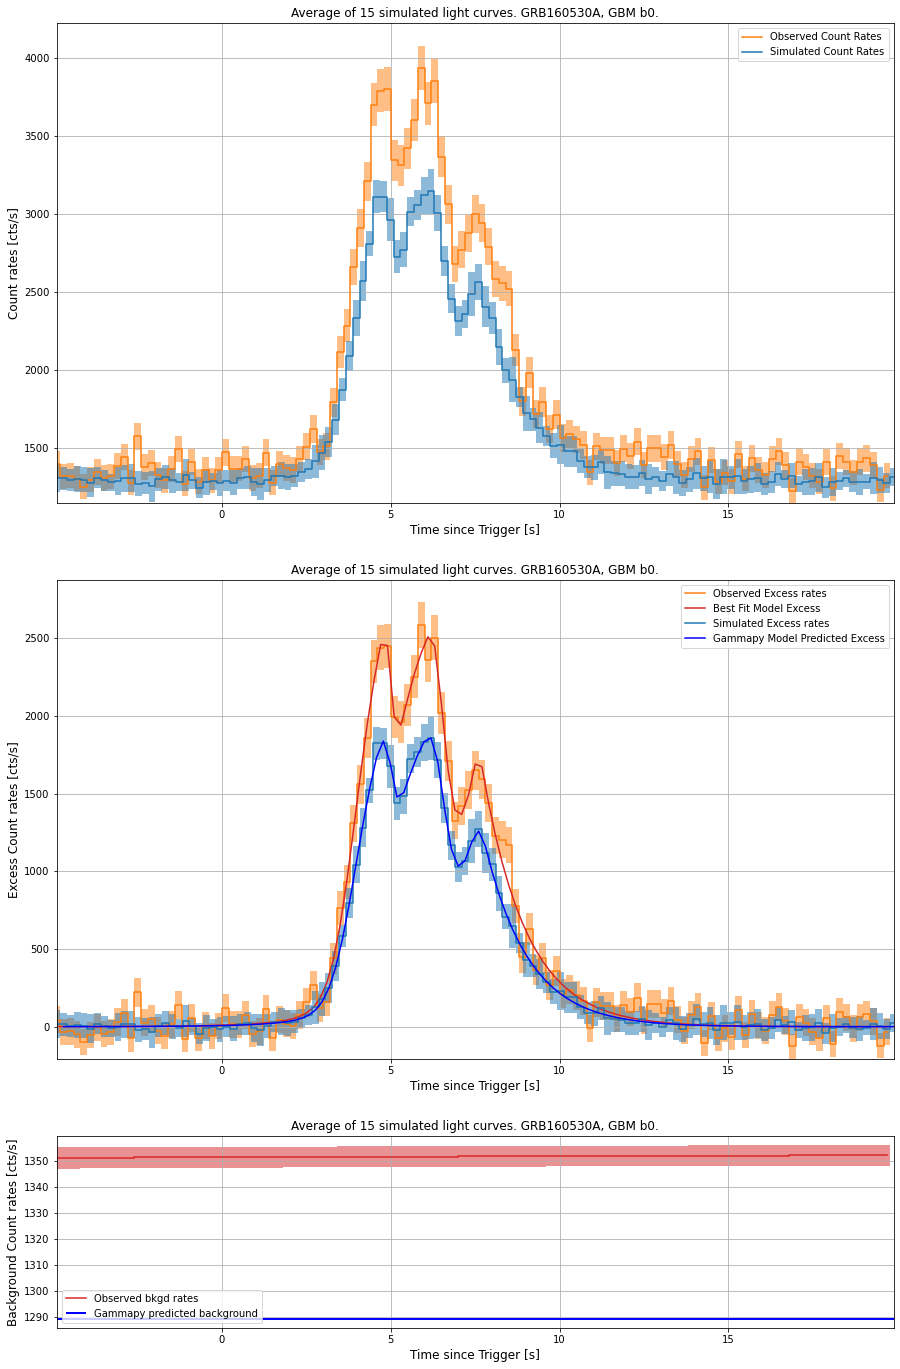

In [43]:
plot_light_curve(avg = True,
                 figsize = (15.0, 24.0),
                 #save_figures_directory = output_directory
                )

Choose one light curve

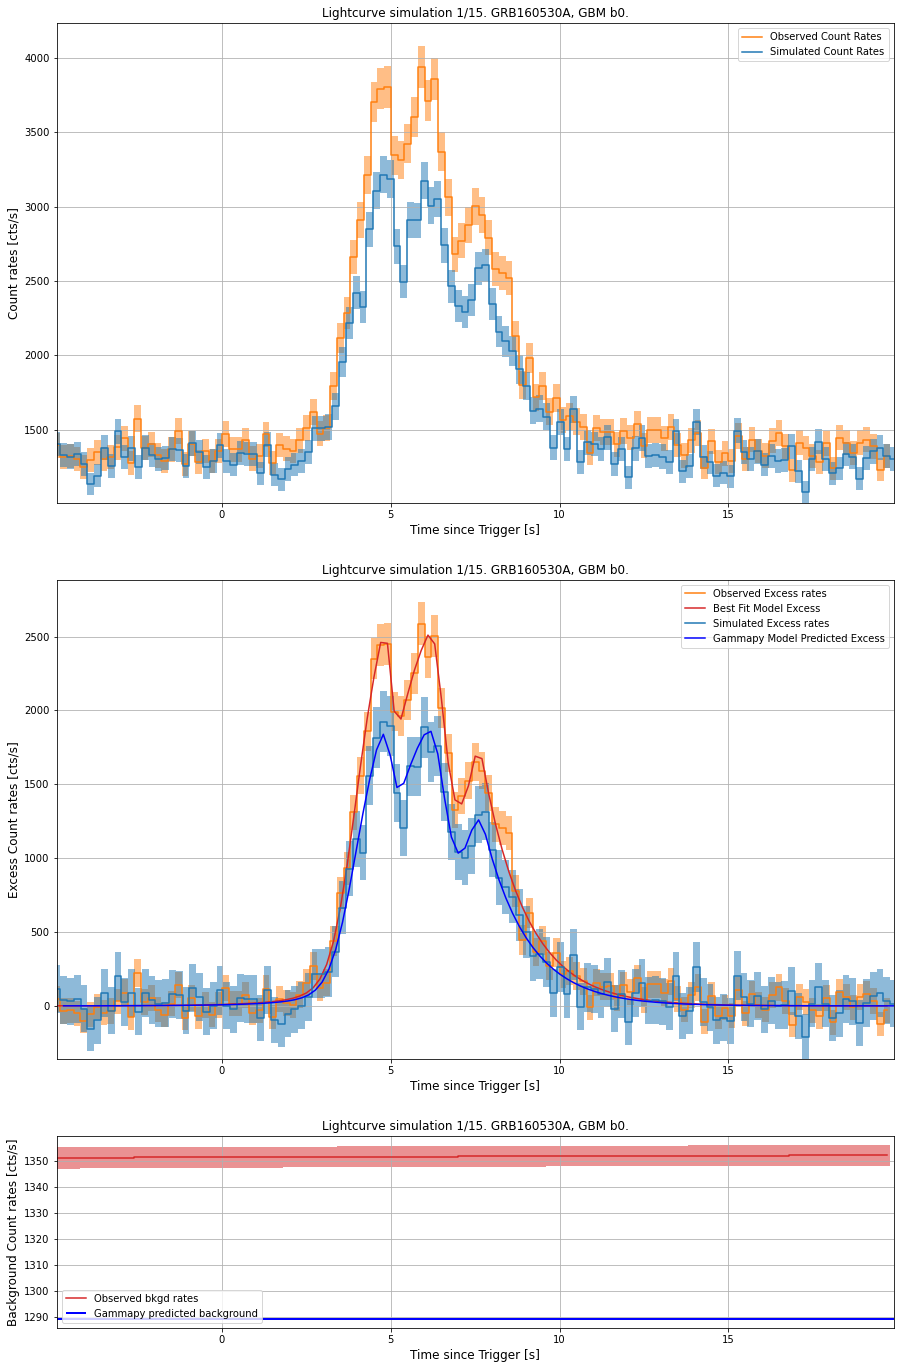

In [44]:
plot_light_curve(avg = False,
                 curve_index = 0,
                 figsize = (15.0, 24.0),
                 #save_figures_directory = output_directory
                )

# Export

In [45]:
hdu_list = []
hdu_list.append(fits.PrimaryHDU())

qtable = QTable(datasets_generic.info_table())
hdu_list.append(fits.table_to_hdu(qtable))

for i_LC in range(Number_of_LightCurves):
    qtable = QTable(List_of_Datasets[i_LC].info_table())
    hdu_list.append(fits.table_to_hdu(qtable))
    
hdu_list = fits.HDUList(hdu_list)

hdu_list.writeto(output_directory+"lightcurves.fits", overwrite=True)
print("Done.")

Done.


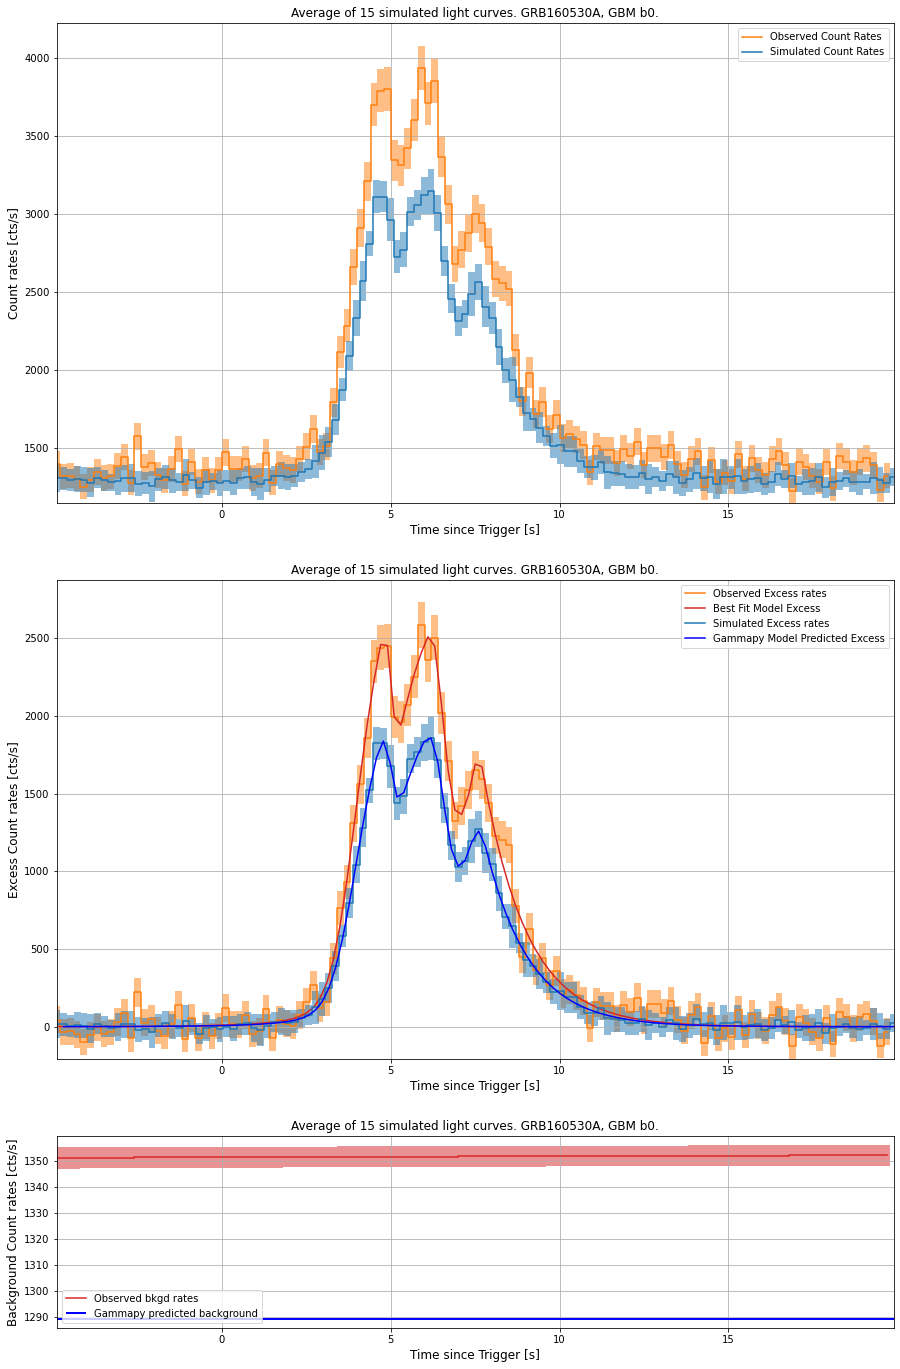

In [46]:
plot_light_curve(avg = True,
                 figsize = (15.0, 24.0),
                 save_figures_directory = output_directory
                )

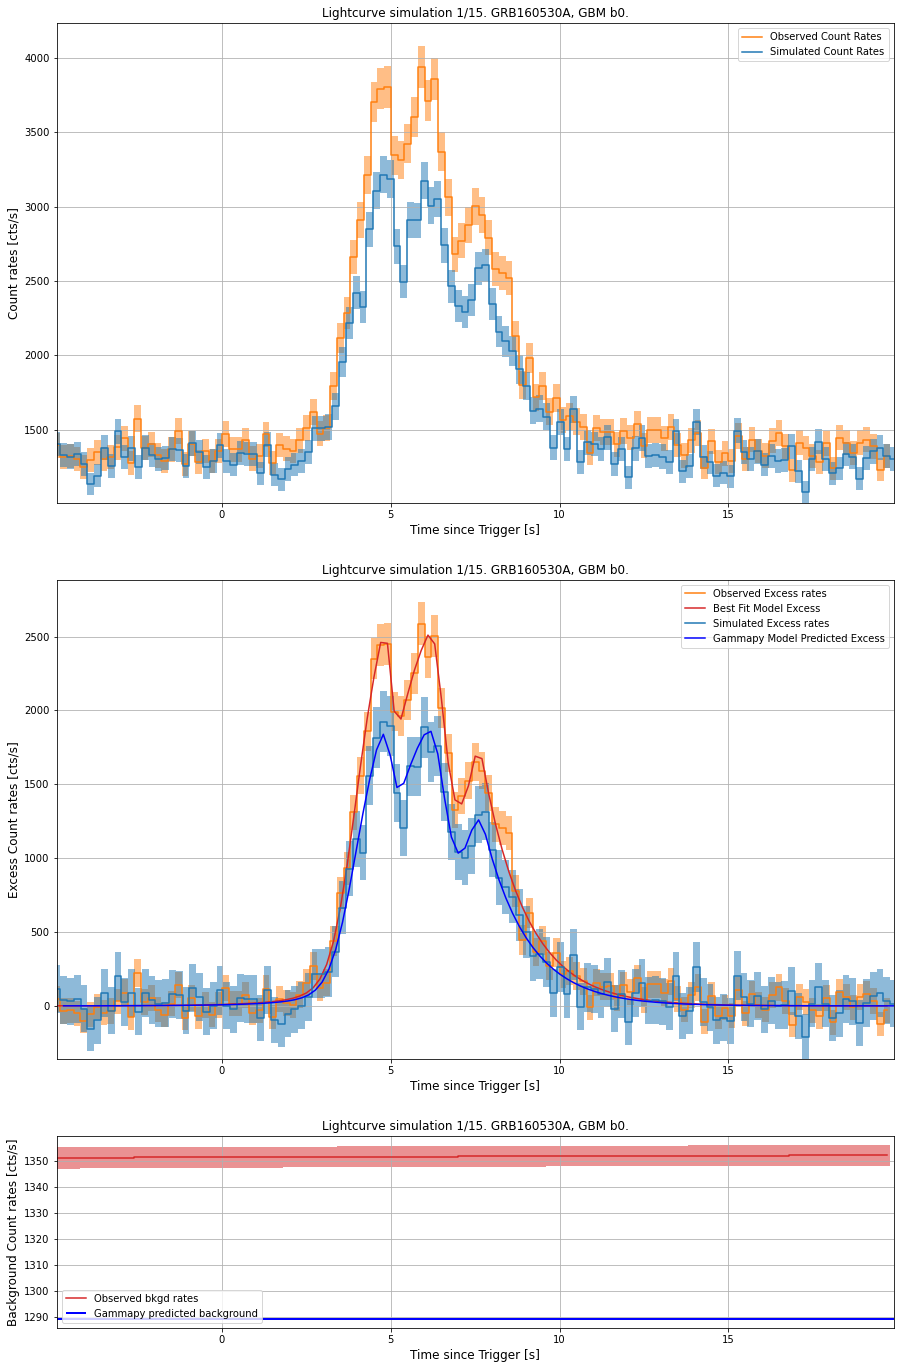

In [47]:
plot_light_curve(avg = False,
                 curve_index = 0,
                 figsize = (15.0, 24.0),
                 save_figures_directory = output_directory
                )

# Flux Points

In [ ]:
# datasets = List_of_Datasets[0]

In [ ]:
# # Drop the Temporal Model, attach only the Spectral Model to all SpectrumDataset objects
# datasets.models = SkyModel(spectral_model = spectral_model, name = "model-fit")
# datasets.models.to_parameters_table()

In [ ]:
# # Estimate a Flux Points light curve, each point is the flux of an observation
# # The estimator fits the norm of the source model component to datasets in each time interval GTI.
# #%%time
# lc_maker_1d = LightCurveEstimator(energy_edges = [axis_energy_true.edges[0], axis_energy_true.edges[-1]],#OR RECO?
#                                   source = "model-fit",
#                                   selection_optional = ["ul"]
#                                  )
# # "all": all the optional steps are executed
# # "errn-errp": estimate asymmetric errors.
# # "ul": estimate upper limits.
# # "scan": estimate fit statistic profiles.

# lc_1d = lc_maker_1d.run(datasets)

In [ ]:
# ax = lc_1d.plot(sed_type = "flux",  # "dnde", “flux”, “eflux”, “e2dnde”
#                 energy_power = 1.0, # Power of energy to multiply flux axis with
#                 marker = "o",
#                 label = "Simulated_LC")

# pl_start = ref_t0 - 0.3 * u.s
# pl_end   = ref_t0 + 0.8 * u.s
# #ax.set_xlim(pl_start.plot_date, pl_end.plot_date)

# Stacked Spectrum

In [ ]:
# datasets = List_of_Datasets[0]

In [ ]:
# Stack the Datasets into one Spectrum Dataset
# Stacked_spectrum_dataset = datasets.stack_reduce(name = 'Stacked_sim_ds')

In [ ]:
# fig, ax = plt.subplots(1, figsize = (7,5))
# Stacked_spectrum_dataset.plot_counts(ax=ax)
# ax.set_xscale('log')
# ax.set_title('Spectrum time-integrated (stacked)')
# plt.grid()
# plt.show()

# Other stuff

In [ ]:
# from gammapy.modeling.models import TemplateNPredModel

# dataset_generic.evaluators['Compt-TwoPulse'].model
# dataset_generic.evaluators['Compt-TwoPulse'].parameter_norm_only_changed
# dataset_generic.evaluators['Compt-TwoPulse'].methods_sequence

# if dataset_generic.evaluators['Compt-TwoPulse'].model.spatial_model:
#     print('spatial model: true')
# else: print('spatial model: false')
    
# print('psf_containment: ',dataset_generic.evaluators['Compt-TwoPulse'].psf_containment)

# flux = dataset_generic.evaluators['Compt-TwoPulse'].compute_flux()

# flux_expo = dataset_generic.evaluators['Compt-TwoPulse'].apply_exposure(flux)
# flux_expo_edisp = dataset_generic.evaluators['Compt-TwoPulse'].apply_edisp(flux_expo)
# dataset_generic.evaluators['Compt-TwoPulse'].edisp


# #print(temporal_model)
# #dataset_generic.npred_signal(model_name='Compt-TwoPulse')